In [1]:
import numpy as np
import pandas as pd
from defillama2 import DefiLlama
import matplotlib.pyplot as plt 
from pmdarima.arima.utils import ndiffs # auto detect the d-value that makes a series stationary
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)
# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
helper_dir = '../scripts/helper'

%run {helper_dir}/check_assumptions.py

### Download Data

Let's download wmatic hourly price data from polygon using DefiLlama's data api. 

In [3]:
dd = {'0x0d500B1d8E8eF31E21C99d1Db9A6444d3ADf1270':'polygon', # wmatic, polygon
      }

# set download start and end dates
start_str = '2022-12-01'
end_str   = '2022-12-18'

In [4]:
llama = DefiLlama()
df = llama.get_tokens_hist_prices(dd, start_str, end_str, 'hourly')
print(df.head(), end='\n\n')
print(df.tail())

                     WMATIC
datetime                   
2022-12-01 00:00:00  0.9315
2022-12-01 01:00:00  0.9290
2022-12-01 02:00:00  0.9213
2022-12-01 03:00:00  0.9218
2022-12-01 04:00:00  0.9261

                     WMATIC
datetime                   
2022-12-17 20:00:00  0.8000
2022-12-17 21:00:00  0.8021
2022-12-17 22:00:00  0.8045
2022-12-17 23:00:00  0.8100
2022-12-18 00:00:00  0.8152


In [5]:
# check missing
df.isna().sum()

WMATIC    0
dtype: int64

In [6]:
matic = df.WMATIC.asfreq('H') # need to set a frequence otherwise model fitting function downstream will warn

In [7]:
# split the series into two parts: training and test
train_stop_time = '2022-12-15 23:00:00'
train = matic[matic.index <= train_stop_time].to_frame()
test  = matic[matic.index > train_stop_time].to_frame()
print('Training data size:', len(train))
print(train.tail(), end='\n\n')
print('Test data size:', len(test))
print(test.head())

Training data size: 360
                     WMATIC
datetime                   
2022-12-15 19:00:00  0.8800
2022-12-15 20:00:00  0.8844
2022-12-15 21:00:00  0.8848
2022-12-15 22:00:00  0.8799
2022-12-15 23:00:00  0.8758

Test data size: 49
                     WMATIC
datetime                   
2022-12-16 00:00:00  0.8750
2022-12-16 01:00:00  0.8846
2022-12-16 02:00:00  0.8846
2022-12-16 03:00:00  0.8871
2022-12-16 04:00:00  0.8878


### Explore Data

Only look at training data to avoid data snooping.

#### Is the price series stationary?

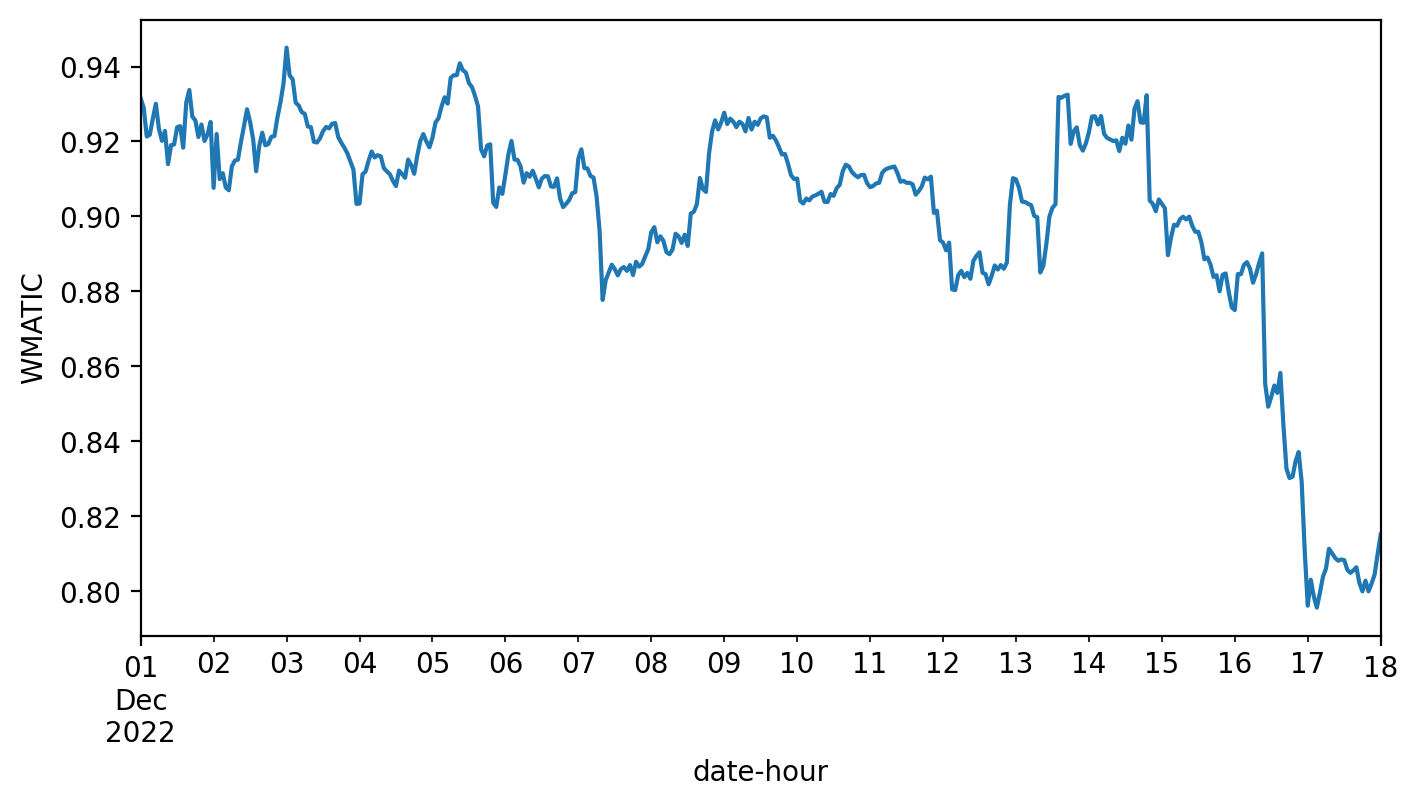

In [8]:
# plot hourly matic prices
matic.plot(y='WMATIC', fontsize=10)
plt.xlabel('date-hour', fontsize=10)
plt.ylabel('WMATIC', fontsize=10)
plt.show()

The price series has a downward trend. Clearly non-stationary. Let's formally check this.

In [9]:
is_price_stationary = check_stationarity(matic)

p-value = 0.8712, and the time series WMATIC is likely non-stationary.


Can't apply ARMA directly cuz it requires stationarity (constant mean and 
variance). But often, taking the difference of the prices will give us a 
stationary series. Let's do that.

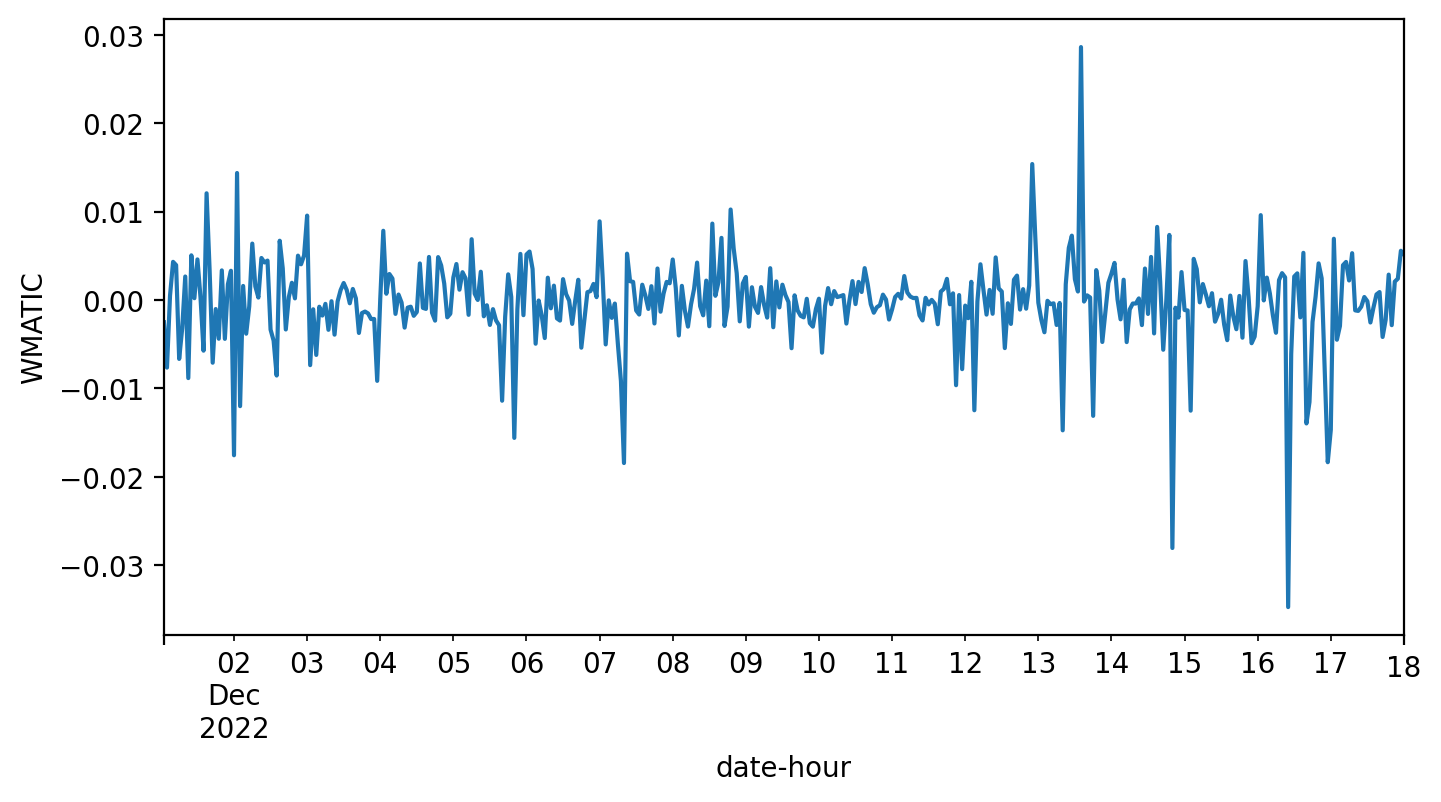

In [10]:
price_diff = matic.diff().dropna()

# plot hourly matic price 1st order differences (current price - prev price)
price_diff.plot(y='WMATIC', fontsize=10)
plt.xlabel('date-hour', fontsize=10)
plt.ylabel('WMATIC', fontsize=10)
plt.show()

The series of 1st order difference looks much better. Let's formally test it and see 
if it is stationary.

In [11]:
is_price_diff_stationary = check_stationarity(price_diff.dropna())

p-value = 0.0, and the time series WMATIC is likely stationary.


Oh ho ho, it is! We can now fit the price differences with a ARMA model. I have
an example of how to do that [here](https://github.com/coindataschool/univ3lp/blob/main/notebooks/forecast-umamieth-arma.ipynb). Alternatively, we can fit a ARIMA model to the 
price series directly with the order of difference set at 1. The order of 
difference is associated with the letter `I` (Integration) in ARIMA. Before we 
move on to fitting a ARIMA model, I want to mention that there's a function in 
the `pmdarima` package called `ndiffs()` that can auto-detect the order of difference 
that makes a series stationary. For example, if we run it on the matic price 
series, we will get 1.

In [12]:
# auto-detect the d value that will result stationary series, 
# if d=1, the first difference is stationary
ndiffs(matic, test='adf') 

1

#### What are good `p`, `q` values?

- `p`: the number of lagged series
- `q`: the number of past errors

I went into the details of how to select appropriate `p` and `q` values for an ARMA model [here](https://github.com/coindataschool/univ3lp/blob/main/notebooks/which-to-use-MA-AR-or-ARMA.ipynb).

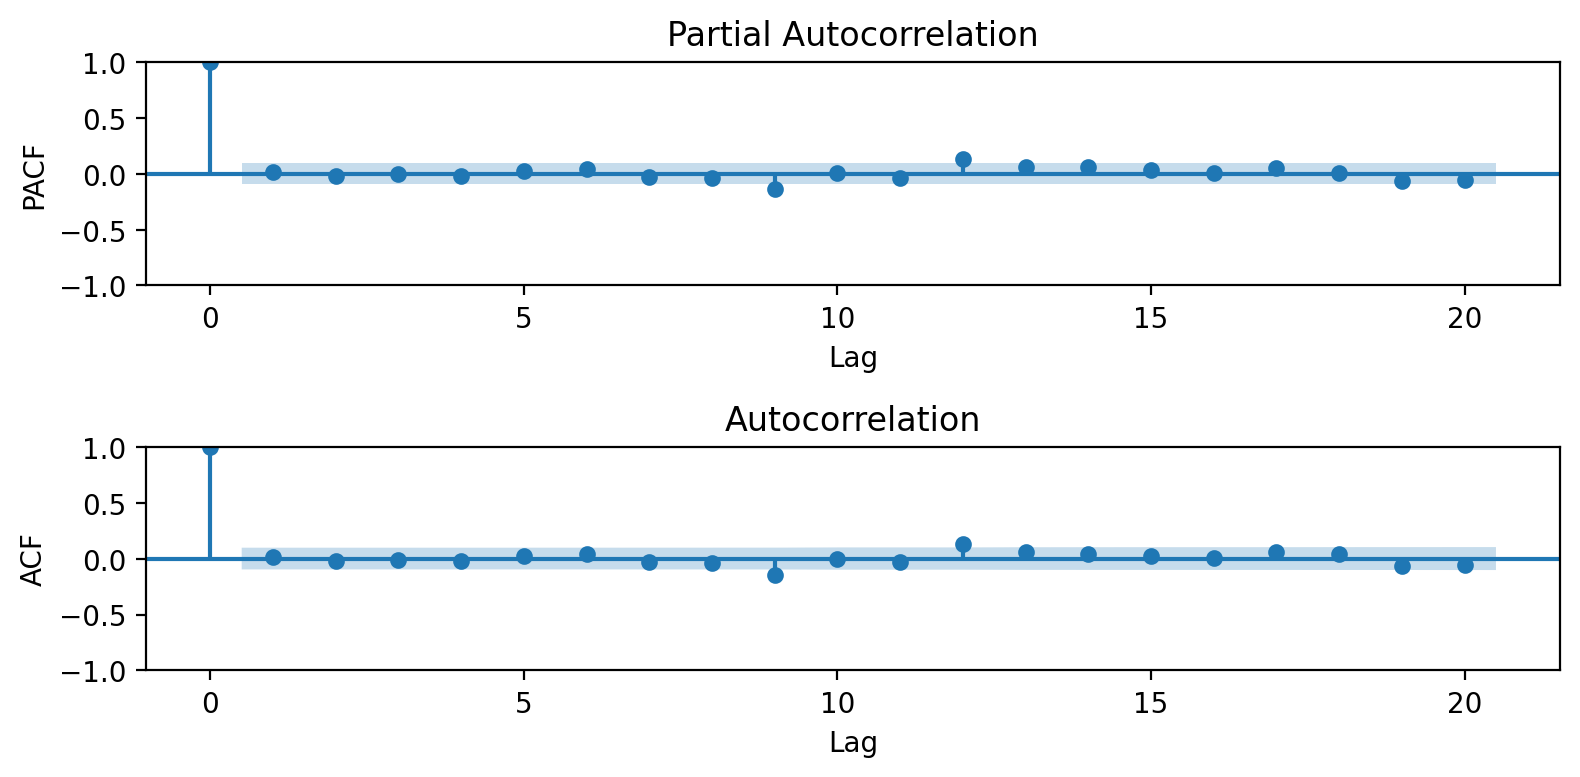

In [13]:
# make ACF and PACF plots
fig, axs = plt.subplots(2)
plot_pacf(price_diff, lags=20, method='ywm', ax=axs[0]) # partial autocorrelation 
axs[0].set_ylabel('PACF')
axs[0].set_xlabel('Lag')
plot_acf(price_diff, lags=20, ax=axs[1])  # autocorrelation
axs[1].set_ylabel('ACF')
axs[1].set_xlabel('Lag')
plt.tight_layout();

Looks like ARMA(0,0) would work on the hourly price differences. This means 
ARIMA(0,1,0) would work on the hourly prices. Let's give it try.

In [14]:
fit0 = ARIMA(price_diff, order=(0,0,0)).fit()
I1 = ARIMA(matic, order=(0,1,0)).fit()

In [15]:
fit0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 WMATIC   No. Observations:                  408
Model:                          ARIMA   Log Likelihood                1581.295
Date:                Sun, 18 Dec 2022   AIC                          -3158.590
Time:                        09:59:26   BIC                          -3150.567
Sample:                    12-01-2022   HQIC                         -3155.415
                         - 12-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -1.097      0.273      -0.001       0.000
sigma2      2.523e-05    7.4e-07     34.111      0.000    2.38e-05    2.67e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2137.01
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
I1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 WMATIC   No. Observations:                  409
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1580.637
Date:                Sun, 18 Dec 2022   AIC                          -3159.275
Time:                        09:59:26   BIC                          -3155.264
Sample:                    12-01-2022   HQIC                         -3157.688
                         - 12-18-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.522e-05   6.87e-07     36.688      0.000    2.39e-05    2.66e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2137.01
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecast next-hour matic price using prior hourly prices with ARIMA model

Scale the training data so that all values are in the range of 0 and 1. Use 
the scaling parameters obtained from training data to scale the test data. This 
avoids data leaking.

In [17]:
# 1. scale data to (0, 1). Notice that we train a scaler() on training data first 
# and apply it to the test set to avoid data leaking.
scaler = MinMaxScaler()
train['WMATIC'] = scaler.fit_transform(train)

# scale test data to be in range(0, 1)
test['WMATIC'] = scaler.transform(test)

# print scaled data
print('Scaled training set:')
print(train.tail(), end='\n\n')
print('Scaled test set:')
print(test.head())

Scaled training set:
                     WMATIC
datetime                   
2022-12-15 19:00:00  0.0620
2022-12-15 20:00:00  0.1255
2022-12-15 21:00:00  0.1307
2022-12-15 22:00:00  0.0599
2022-12-15 23:00:00  0.0000

Scaled test set:
                     WMATIC
datetime                   
2022-12-16 00:00:00 -0.0102
2022-12-16 01:00:00  0.1283
2022-12-16 02:00:00  0.1274
2022-12-16 03:00:00  0.1638
2022-12-16 04:00:00  0.1743


#### Iterative training and forecasting

Let's train an ARMA(0, 1, 0) model and make forecasts iteratively on a rolling 1-step 
basis. That is, as we iterate over the timestamps in the test set, we will

1. train an ARMA(0, 1, 0) on the training set,
2. make a 3-step forecast, i.e., predict for the next 1, 2, 3 hours,
3. grow the training set by including the test set observation at that timestamp.

In [18]:
# how many records do you want to use for initial training? 
# set len(train) to use full training data. But we probably want to use a subset
# of more recent data since momentum breaks over a long period. Here I'm using 
# the previous 5 days, and each day has 24 hours. 
training_size = 5 * 24 

# extract training and test timeseries
ts_train = train.WMATIC[-training_size:]
ts_test = test.WMATIC

# change to list because we'll need to pop() and append() to training series
ts_train = list(ts_train)

In [19]:
# how many steps ahead do you want to forecast?
horizon = 3

In [20]:
# iterative ARMA(1,1) fitting and forecasting
predictions = list()
for t in range(len(ts_test)):
    model = ARIMA(ts_train, order=(0,1,0)).fit()
    yhat = model.forecast(steps=horizon) # forecast() gives a numpy array
    obs = ts_test[t]
    predictions.append(yhat)
    # grow training timeseries by adding current test set observation to the end
    ts_train.append(obs)

/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gmlang/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
# make actual test series into a frame according to forecast horizon
df_actuals = pd.DataFrame({
    'WMATIC_t{}'.format(t+1): test.WMATIC.shift(-t) for t in range(horizon)})
df_actuals.head()

,WMATIC_t1,WMATIC_t2,WMATIC_t3
datetime,,,
2022-12-16 00:00:00,-0.0102,0.1283,0.1274
2022-12-16 01:00:00,0.1283,0.1274,0.1638
2022-12-16 02:00:00,0.1274,0.1638,0.1743
2022-12-16 03:00:00,0.1638,0.1743,0.1487
2022-12-16 04:00:00,0.1743,0.1487,0.0950


In [22]:
# reverse the scaling operation to get back at the original scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(df_actuals)

In [23]:
# put acutals and predictions side by side in the same data frame
df_pred = pd.DataFrame(
    np.concatenate([actuals, predictions], axis=1), 
    columns=list(df_actuals.columns) + ['forecast_t{}'.format(t+1) for t in range(horizon)], 
    index=test.index)
df_pred.head()

,WMATIC_t1,WMATIC_t2,WMATIC_t3,forecast_t1,forecast_t2,forecast_t3
datetime,,,,,,
2022-12-16 00:00:00,0.8750,0.8846,0.8846,0.8758,0.8758,0.8758
2022-12-16 01:00:00,0.8846,0.8846,0.8871,0.8750,0.8750,0.8750
2022-12-16 02:00:00,0.8846,0.8871,0.8878,0.8846,0.8846,0.8846
2022-12-16 03:00:00,0.8871,0.8878,0.8861,0.8846,0.8846,0.8846
2022-12-16 04:00:00,0.8878,0.8861,0.8823,0.8871,0.8871,0.8871


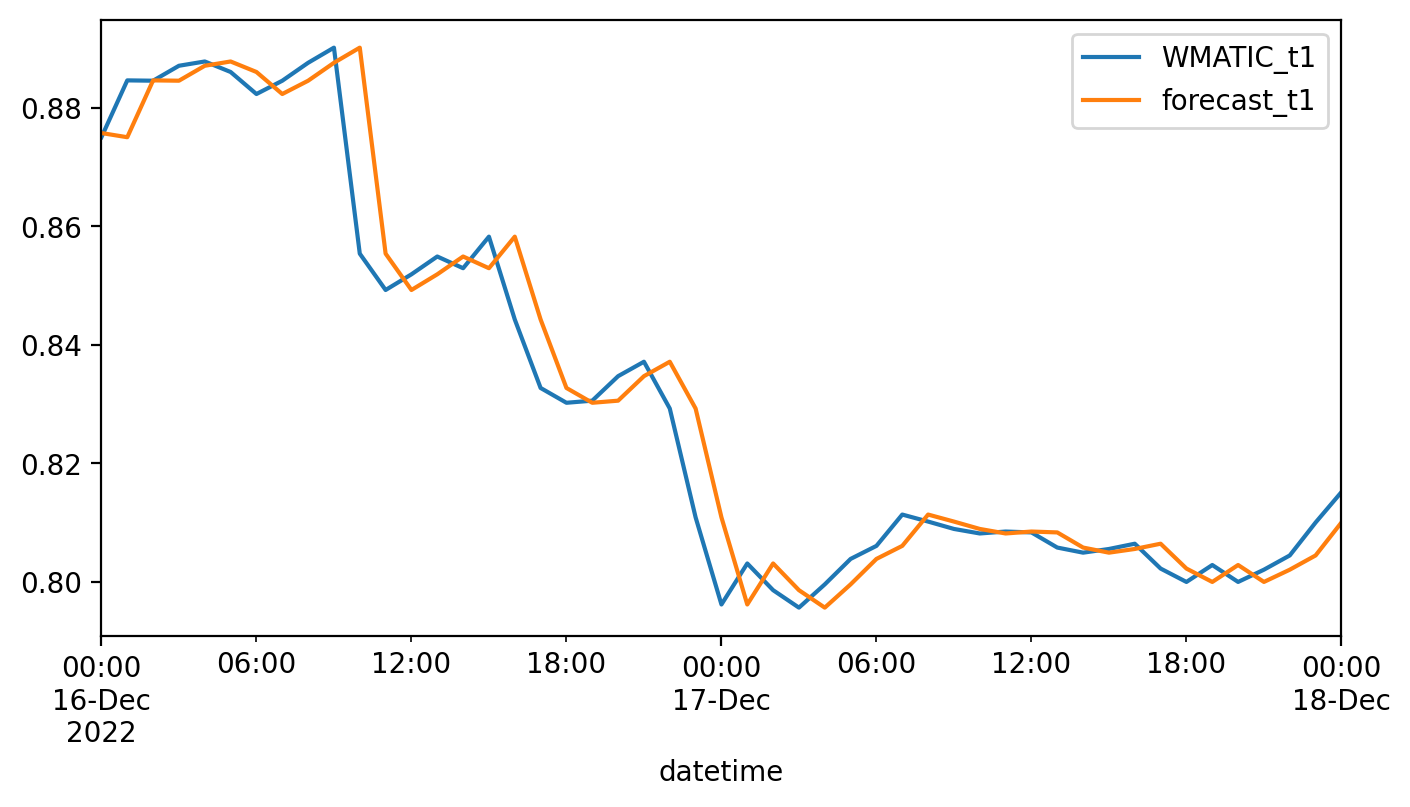

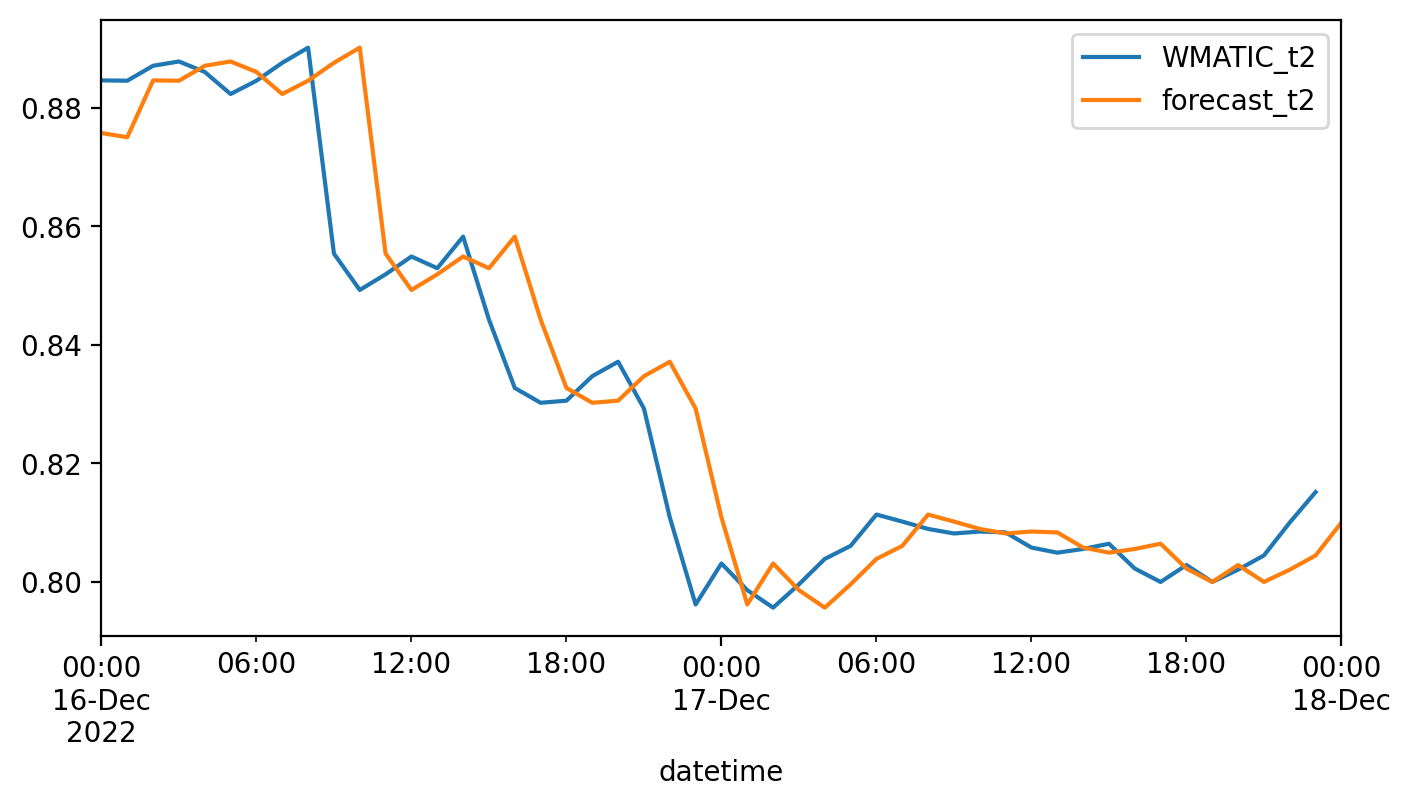

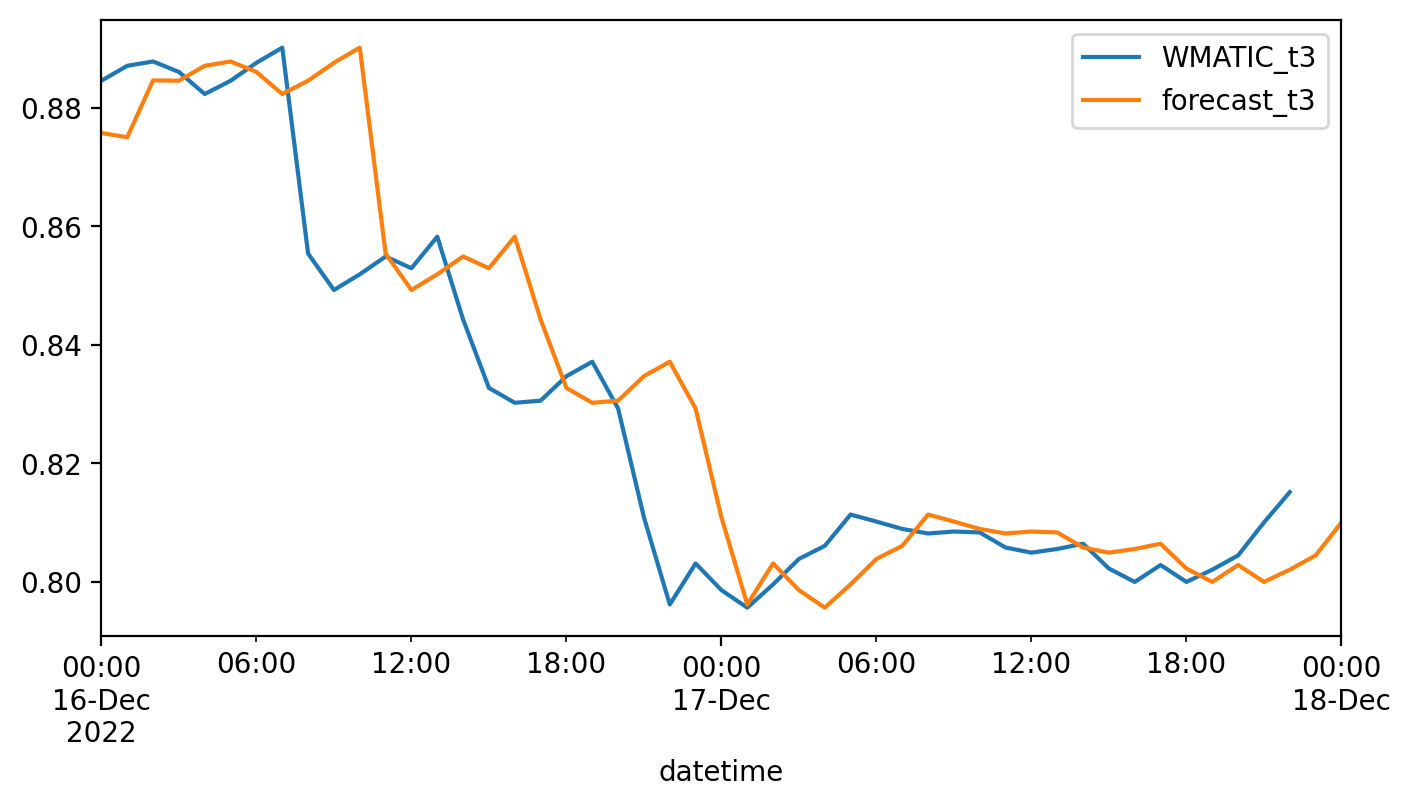

In [24]:
# plot forecast vs observations
df_pred[['WMATIC_t1', 'forecast_t1']].plot();
df_pred[['WMATIC_t2', 'forecast_t2']].plot();
df_pred[['WMATIC_t3', 'forecast_t3']].plot();

Our forecasts become worse as we try to predict more distance into the future. 
This is expected! Let's now calculate the average prediction error, which we can 
use to compare against other models on the same data.

In [25]:
def MAPE(actuals, predictions):
    """Calculate mean absolute percentage error"""
    return (abs(actuals - predictions) / actuals).mean()

one_step_mape = MAPE(df_pred.WMATIC_t1, df_pred.forecast_t1)

multi_step_mape = 0
for t in range(horizon):
    actuals = df_pred['WMATIC_t{}'.format(t+1)]
    forecasts = df_pred['forecast_t{}'.format(t+1)]
    multi_step_mape += MAPE(actuals, forecasts)
multi_step_mape /= horizon 

print("1-step forecast MAPE: ", format(one_step_mape, '.3%'))
print('{}-step forecast MAPE: '.format(horizon), format(multi_step_mape, '.3%'))

1-step forecast MAPE:  0.547%
3-step forecast MAPE:  0.850%
